# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS-109A Introduction to Data Science


## Lab 10: Decision Trees (Part 2 of 2): Boosting!

**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors:** Pavlos Protopapas, Kevin Rader, and Chris Tanner<br/>
**Lab Instructors:** Chris Tanner and Eleni Kaxiras<br/>
**Authors:** Kevin Rader, Rahul Dave, Chris Tanner

In [1]:
## RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

## Learning Goals

The goal of this lab is for students to:

<ul>
  <li>Understand the core concepts of Bagging and RandomForest (and the difference between the two)</li>
  <li>Understand why Boosting can be important</li>
  <li>Understand how Boosting works (conceptually)</li>
  <li>Feel comfortable writing code in `sklearn` to run Adaboost</li>
</ul>  

In [3]:
# imports
%matplotlib inline
import numpy as np
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostRegressor
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
# import seaborn.apionly as sns

## Background

Before we move on to boosting, let's first recap what we learned in last lab and lecture about decision trees, along with a refresher on bias vs variance.

<div class="exercise"><b>Q1:</b> For a given dataset, say we trained a DecisionTree of depth 3 (a root node with children, then terminal leaves). What can you speculate about its variance and bias? What if our tree had a depth of 12? Let's discuss.</div>

In [9]:
# SOLUTION: discussed in lab
%load solutions/q1.txt

IndentationError: unexpected indent (<ipython-input-9-4da7b2e3b8b8>, line 2)

We know that Decision Trees are useful models because they offer:

<ul>
  <li>the ability to model non-linear relationships of data</li>
  <li>interpretable results (if we don't aggregate trees)</li>
  <li>insensitivity to outliers and unscaled data</li>
</ul> 

<div class="exercise"><b>Q2:</b> What is Bagging and why is it useful?</div>

In [21]:
# SOLUTION: discussed in lab

<div class="exercise"><b>Q3:</b> What is RandomForest and why is it useful?</div>

In [22]:
# SOLUTION: discussed in lab

<div class="exercise"><b>Q4:</b> What are potential weaknesses with Bagging and RandomForest?</div>

In [23]:
# SOLUTION: discussed in lab

## Understanding Boosting

My goal is for none of the topics we learn in this class to seem like nebulus concepts or black-boxes of magic. In this course, it's important to understand the models that you can use to help you with your data, and this includes not only knowing how to invoke these as tools within Python libraries (e.g., ``sklearn``, ``statsmodels``), but to have an understanding of what each model is actually doing 'under the hood' -- how it actually works -- as this provides insights into why you should use one model vs another, and how you could adjust models and invent new ones!


### Gradient Boosting

In Lecture 17, Pavlos introduced Boosting by first talking about Gradient Boosting.

<div class="exercise"><b>Q5:</b> What is the motivation for Boosting in general?</div>

In [24]:
# SOLUTION: discussed in lab. in short, we should learn from our mistakes and weight the predictions of our past models (based on their accuracy)

<div class="exercise"><b>Q6:</b> What is Gradient Boosting?</div>

In [25]:
# SOLUTION: discussed in lab

<div class="exercise"><b>Q7:</b> What is AdaBoost?</div>

In [26]:
# SOLUTION: discussed in lab

Let's walk through how AdaBoost works, via slides (`AdaBoost.pptx` and `AdaBoost.pdf`).

### Summary:

In summary, none of the models we've previously discussed have the ability to learn from their final predictions, which is what boosting allows us to do. Sure, we train a model iteratively over data (possibly multiple epochs), but its final predictions/errors are never used to train new models. Boosting allows us to do this, and it tends to use a bunch of 'weak' models. The reason for using weak models is that if we used very expressive models, our combined models would likely overfit pretty quickly. In short, we should learn from our models' mistakes. Gradient Boosting is typically used for regression tasks, as it models the residuals. AdaBoost is typically used for classification tasks. AdaBoost explicitly weights the dataset for each model based on the previous mdoels' misclassifications. That is, our dataset is constantly being changed after each model, based on the misclassification from our accumulative model. Moreover, the model's accuracy is used for determining how much weight (aka, how much stock or faith) we should place on that given model.

My slides, `AdaBoost.pptx/pdf`, go into more detail.

If you are looking for further details, I highly recommend [CMU's slides from their Machine Learning Algorithms course.](https://www.cs.cmu.edu/~atalwalk/teaching/winter17/cs260/lectures/lec13.pdf)

## Sklearn's Implementation

Our beloved `sklearn` library has an implementation of AdaBoost, so let's practice using it.

Let's load in the same dataset that we used in the last lab -- `county_level_election.csv`

In [11]:
elect_df = pd.read_csv("../data/county_level_election.csv")
elect_df.head()

,state,fipscode,county,population,hispanic,minority,female,unemployed,income,nodegree,bachelor,inactivity,obesity,density,cancer,votergap,trump,clinton
0,Colorado,8117,Summit County,27239,15.173,4.918,45.996,2.5,68352,5.4,48.1,8.1,13.1,46.0,46.2,-27.632,31.530,59.162
1,Colorado,8037,Eagle County,53653,30.040,5.169,47.231,3.1,76661,10.1,47.3,9.4,11.8,31.0,47.1,-19.897,36.058,55.955
2,Idaho,16067,Minidoka County,19226,34.070,5.611,49.318,3.7,46332,24.1,11.8,18.3,34.2,80.0,61.8,54.148,71.135,16.987
3,Colorado,8113,San Miguel County,7558,10.154,4.747,46.808,3.7,59603,4.7,54.4,12.4,16.7,5.7,62.6,-44.769,23.892,68.662
4,Utah,49051,Wasatch County,21600,13.244,4.125,48.812,3.4,65207,9.5,34.4,13.9,23.0,257.8,68.3,25.357,50.471,25.114


In [12]:
# NOTICE that a negative votergap means more people voted for clinton than trump; a positive votergap means more people voted for trump

# split 80/20 train-test
X = elect_df[['population','hispanic','minority','female','unemployed','income','nodegree','bachelor','inactivity','obesity','density','cancer']]
response = elect_df['votergap']
Xtrain, Xtest, ytrain, ytest = train_test_split(X,response,test_size=0.2)

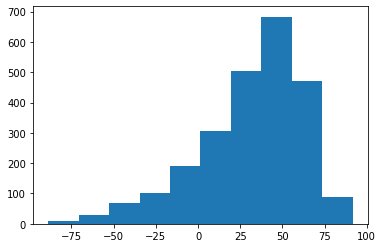

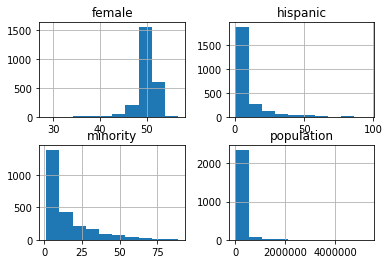

In [30]:
# let's plot a few of our features
plt.hist(ytrain)
Xtrain.hist(column=['minority', 'population','hispanic','female']);

We can build a DecisionTree classifier as follows:

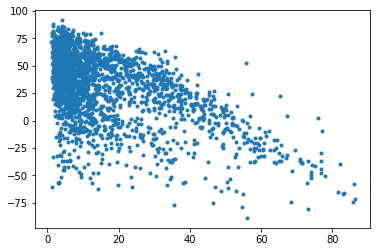

In [13]:
# let's plot our `minority` values
from sklearn.tree import DecisionTreeRegressor
x = Xtrain['minority'].values
o = np.argsort(x)
x = x[o]
y = ytrain.values
y = y[o]
plt.plot(x,y, '.');

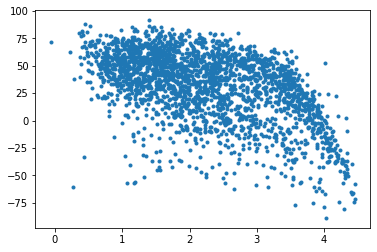

In [14]:
plt.plot(np.log(x),y, '.'); # log scale

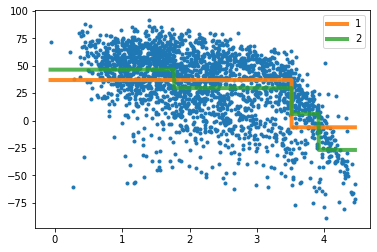

In [15]:
# as we saw in lab 9, this is what happens when we fit 2 different standard Decision Trees to our data
plt.plot(np.log(x),y,'.')
xx = np.log(x).reshape(-1,1)
for i in [1,2]:
    dtree = DecisionTreeRegressor(max_depth=i)
    dtree.fit(xx, y)
    plt.plot(np.log(x), dtree.predict(xx), label=str(i), alpha=1-i/10, lw=4)
plt.legend();

In [19]:
estab = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=1), n_estimators=200, learning_rate=1.0)
estab.fit(xx, y)
staged_predict_generator = estab.staged_predict(xx)

<generator object AdaBoostRegressor.staged_predict at 0x1a2783a228>


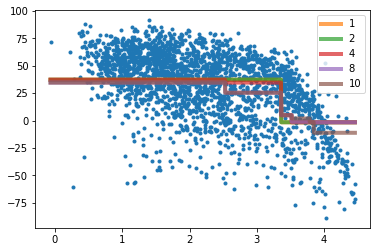

In [17]:
import time
from IPython import display
plt.plot(xx, y, '.');
counter = 0
for stagepred in staged_predict_generator:
    counter = counter + 1
    if counter in [1, 2, 4, 8, 10, 50, 100, 200]:
        plt.plot(xx, stagepred, alpha=0.7, label=str(counter), lw=4)
        plt.legend();
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(1)

Ok, so this demonstration helps us understand some things about boosting.

- `n_estimators` is the number of trees, and thus the stage in the fitting. It also controls the complexity for us. The more trees we have the more we fit to the tiny details.
- `staged_predict` gives us the prediction at each step
- once again `max_depth` from the underlying decision tree tells us the depth of the tree. But here it tells us the amount of features interactions we have, not just the scale of our fit. But clearly it increases the variance again.

Ideas from decision trees remain. For example, increase `min_samples_leaf` or decrease `max_depth` to reduce variance and increase the bias.

<br>
<div class="exercise"><b>Group Exercise 1:</b></div>
<br>

1: What do you expect to happen if you increase `max_depth` to 5?  Edit the code above to explore the result.

2: What do you expect to happen if you put `max_depth` back to 1 and decrease the `learning_rate` to 0.1?  Edit the code above to explore the result.

3: Do a little work to find some sort of 'best' values of `max_depth` and `learning_rate`.  Does this result make sense?

#### Your answer here

### AdaBoost Classification

Let's start with the same voter data from above:

In [21]:
X = elect_df[['population','hispanic','minority','female','unemployed','income','nodegree','bachelor','inactivity','obesity','density','cancer']]
response = elect_df['votergap']
Xtrain, Xtest, ytrain, ytest = train_test_split(X,response,test_size=0.2)

<br>
<div class="exercise"><b>Group Exercise 2:</b></div>
<br>
Convert the y-values to being binary, whereby any negative values become a 0 (more people voted for Clinton) and any positive values become a 1 (more people voted for Trump).

<br>
<div class="exercise"><b>Group Exercise 3:</b></div>
<br>
Create an AdaBoostClassifier to predict our binary classification task. Below we provide a code snippet. Are there any issues along the way? Are our features okay to use as is? Be sure to output your prediction accuracy.

In [22]:
from sklearn.ensemble import AdaBoostClassifier
ada_model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=10, learning_rate=.01).fit(Xtrain, ytrain)

ValueError: Unknown label type: 'continuous'

<br>
<div class="exercise"><b>Group Exercise 4:</b></div>
<br>

Experiment with the different parameters, which are listed in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier). Be sure to pay attention to the algorithm parameter. What is the difference between SAMME and SAMME.R?

What's the best performance that you can achieve? And how does this compare with a more simple baseline (use either Bagging, RandomForest, or a single Decision Tree).